# **Pipeline de Dados do Telegram**

# 1. Contexto:

# 1.1 Chatbot

Um **chatbot** é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de **chatbots** é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

# 1.2 Telegram

**Telegram** é uma plataforma de mensagens instantâneas freeware (distribuído gratuitamente) e, em sua maioria, open source. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de **chatbots**, que, por sua vez, permitem a criação de diversas automações.

# 1.3 Arquitetura

Uma atividade analítica de interesse é a de realizar a análise exploratória de dados enviadas a um **chatbot** para responder perguntas como:

1. Qual o horário que os usuários mais acionam o bot?
2. Qual o problema ou dúvida mais frequente?
3. O bot está conseguindo resolver os problemas ou esclarecer as dúvidas?

Portanto, vamos construir um pipeline de dados que ingira, processe, armazene e exponha mensagens de um grupo do **Telegram** para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no **Telegram**, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

![](http://github.com/nildomuniz/ebac-analista-dados/blob/main/9.Big_Data_LataLake_AWS/modulo_44_arch.png?raw=true)

* **AWS | Ingestão**

Uma requisição HTTP com o conteúdo da mensagem em seu payload é recebia pelo AWS API Gateway que, por sua vez, as redireciona para o AWS Lambda , servindo assim como seu gatilho. Já o AWS Lambda recebe o payload da requisição em seu parâmetro event, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o payload) e o armazena no AWS S3 particionado por dia.

* **AWS | ETL**

Uma vez ao dia, o AWS Event Bridge aciona o AWS Lambda que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no AWS S3 particionado por dia.

* **AWS | Apresentação**

Por fim, uma tabela do AWS Athena é apontada para o bucket do AWS S3 que armazenao dado processado: denormalizado, particionado e orientado a coluna. Profissionais de
dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de insights.

# 2. Telegram

O **Telegram** representa a fonte transacional de dados do nosso pipeline de dados. Nesta etapa, vamos criar um grupo, criar um **bot** e adiciona-lo ao grupo recém criado. O bot então captará todas as mensagens enviadas no grupo. As mensagens pode ser acessadas através da API (application programming interface) de bots dos **Telegram** (documentação neste [link](https://core.telegram.org/bots/api).

**2.1 Conta**

Para criar uma conta no **Telegram**, basta fazer o download do aplicativo na loja de aplicativos do seu smartphone. Uma vez criada, acesse sua conta através da versão web da
plataforma de mensagens neste [link](https://web.telegram.org/k/).

**2.2 Bot**

Para criar um bot:
1. Abra o chat com o BotFather ;
2. Digite /newbot ;
3. Digite o nome do bot;
4. Digite o nome de usuário do bot (precisa terminar com sufixo _bot );
5. Salve o token de acesso a API HTTP em um local seguro.

Para conferir o token novamente:

1. Abra o chat com o BotFather ;
2. Digite /mybots ;
3. Selecione o bot pelo seu nome de usuário;
4. Selecione API Token .

Por fim, precisamos ativiar o bot.
1. Abra o chat com o bot;
2. Selecione start .

**2.3 Grupo**

Para criar um novo grupo:
1. Aperte o botão com o ícone de um lápis;
2. Selecione New Group ;
3. Busque e selecione o bot recém criado pelo seu nome;
4. Aperte o botão com o ícone de uma seta;
5. Digite o nome do grupo.

Com o grupo criado, vamos adicionar o bot como administrador para que ele possa receber todas as mensagens do grupo. Uma outra opção seria desabilitar o seu modo de privacidade.

1. Abra o chat do grupo recém criado;
2. Abra o perfil do grupo;
3. Aperte o botão com o ícone de um lápis;
4. No campo de descrição do grupo escreva: Atenção, todas as mensagens são armazenadas pelo bot do grupo;
5. Selecione Administrators;
6. Aperte o botão com o ícone de um usuário;
7. Selecione o bot.
8. Aperte o botão com o ícone de um check.

Por fim, vamos configurar o bot para que ele não possa ser adicionado a outros grupos:

1. Abra o chat com o BotFather ;
2. Digite /mybots ;
3. Selecione o bot pelo seu nome de usuário;
4. Selecione Bot Settings ;
5. Selecione Allow Groups? ;
6. Selecione Turn groups off .

Com tudo pronto, envie algumas mensagens no grupo.

**2.4 Bot API**

As mensagens captadas por um bot podem ser acessadas via API. A única informação necessária é o token de acesso fornecido pelo BotFather na criação do bot.

> **Nota:** A documentação completa da API pode ser encontrada neste [link](https://core.telegram.org/bots/api).

In [ ]:
from getpass import getpass

token = getpass()

A url base é comum a todos os métodos da API.

In [ ]:
import json
import requests
base_url = f'https://api.telegram.org/bot{token}'

* **getMe**

O método getMe retorna informações sobre o bot.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')
print(json.dumps(json.loads(response.text), indent=2))

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Projetos/1%20-%20getMe.png?raw=true)

* **getUpdates**

O método getMe retorna as mensagens captadas pelo bot.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')
print(json.dumps(json.loads(response.text), indent=2))

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Projetos/2-%20getUpdates.png?raw=true)

# 3. Ingestão

A etapa de ingestão é responsável, como seu o próprio nome diz, pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura (schema). Como exemplo, dados de uma API web que segue o formato REST (representational state transfer) são entregues, logo, persistidos, no formato JSON.

> Persistir os dados em seu formato original trás muitas vantagens, como a possibilidade de reprocessamento.

Pode ser conduzida de duas formas:

* **Batch**: blocos de dados são ingeridos em uma frequência bem definida, geralmente na escala de horas ou dias;
* **Streaming**: dados são ingeridos conforme são produzidos e disponibilizados.

No projeto, as mensagens capturadas pelo bot podem ser ingeridas através da API web de bots do Telegram, portanto são fornecidos no formato JSON. Como o Telegram retem mensagens por apenas 24h em seus servidores, a ingestão via streaming é a mais indicada. Para que seja possível esse tipo de ingestão seja possível, vamos utilizar um webhook (gancho web), ou seja, vamos redirecionar as mensagens automaticamente para outra API web.

Sendo assim, precisamos de um serviço da AWS que forneça um API web para receber os dados redirecionados, o AWS API Gateway (documentação neste link). Dentre suas diversas funcionalidades, o AWS API Gateway permite o redirecionamento do dado recebido para outros serviços da AWS. Logo, vamos conecta-lo ao AWS Lambda, que pode sua vez, irá armazenar o dado em seu formato original (JSON) em um bucket do **AWS S3**.

> Sistemas que reagem a eventos são conhecidos como event-driven.


Portanto, precisamos:

* Criar um bucket no AWS S3;
* Criar uma função no AWS Lambda;
* Criar uma API web no AWS API Gateway;
* Configurar o webhook da API de bots do **Telegram**.

> **Criando um Bucket no AWS**:

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/1-bucket_criado.png?raw=true)

> **Criando uma função no AWS Lambda:**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/2-lambda_criado.png?raw=true)

**3.1 AWS S3**

Na etapa de **ingestão**, o AWS S3 tem a função de passivamente armazenar as mensagens captadas pelo bot do **Telegram** no seu formato original: JSON. Para tanto, basta a criação de um bucket. Como padrão, vamos adicionar o sufixo -raw ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

> **Nota**: um data lake é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: raw e enriched ou bronze, silver e gold.

**3.2 AWS Lambda**

Na etapa de ingestão, o AWS Lambda tem a função de ativamente persistir as mensagens captadas pelo bot do Telegram em um bucket do AWS S3. Para tanto vamos criar uma função que opera da seguinte forma:

* Recebe a mensagem no parâmetro event;
* Verifica se a mensagem tem origem no grupo do **Telegram** correto;
* Persiste a mensagem no formato JSON no bucket do AWS S3;
* Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de bots do **Telegram**.

> **Nota**: No **Telegram**, restringimos a opção de adicionar o bot a grupos, contudo, ainda é possível iniciar uma conversa em um chat privado.

O código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

  # message = json.loads(event["body"])
    message = event
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

* **Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: AWS_S3_BUCKET com o nome do bucket do AWS S3 e TELEGRAM_CHAT_ID com o id do chat do grupo do **Telegram**. Para adicionar variáveis de ambiente em uma função do AWS Lambda, basta acessar configurações -> variáveis de ambiente no console da função.

> **Nota**: Variáveis de ambiente são excelentes formas de armazenar informações sensíveis.


> **Variáveis de ambiente criadas**:

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/4-Variaveis%20de%20ambiente_criada.png?raw=true)

* **Permissão**

Por fim, precisamos adicionar a permissão de escrita no bucket do AWS S3 para a função do AWS Lambda no AWS IAM.

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/5%20-politicaAnexada.png?raw=true)

> **Configurando Evento de Teste no Lambda para conferir integração no S3**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/7-lambdaExecutado.png?raw=true)

> **Verificando no S3**

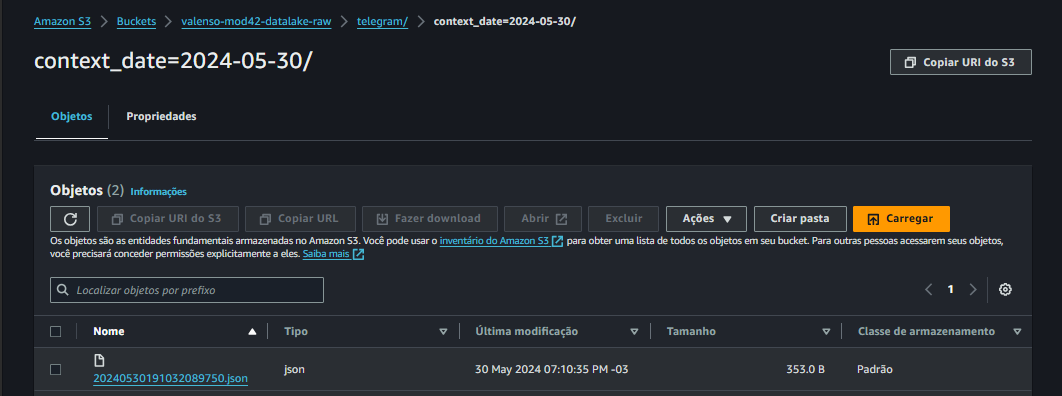

> **Evento de teste bem sucedido**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/12-atualizadorecomentado.Json.png?raw=true)

* **3.3 AWS API Gateway**

Na etapa de **ingestão**, o AWS API Gateway tem a função de receber as mensagens captadas pelo bot do **Telegram**, enviadas via webhook, e iniciar uma função do AWS Lambda, passando o conteúdo da mensagem no seu parâmetro event. Para tanto vamos criar uma API e configurá-la como gatilho da função do AWS Lambda:

* Acesse o serviço e selecione: Create API -> REST API;
* Insira um nome, como padrão, um que termine com o sufixo -api;
* Selecione: Actions -> Create Method -> POST;
* Na tela de setup:
    * Selecione Integration type igual a Lambda Function;
    * Habilite o Use Lambda Proxy integration;
    * Busque pelo nome a função do AWS Lambda.
    
Podemos testar a integração com o AWS Lambda através da ferramenta de testes do serviço. Por fim, vamos fazer a implantação da API e obter o seu endereço web.

* Selecione: Actions -> Deploy API;
* Selecione: New Stage para Deployment stage;
* Adicione dev como Stage name.


Copie o a url gerada na variável aws_api_gateway_url.

In [ ]:
aws_api_gateway_url = getpass()

> **Criando uma API no AWS API Gateway e a conectando a função do AWS Lambda, conforme apresentado na aula.**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/13-apiCriada.png?raw=true)

* **3.4 Telegram**

Vamos configurar o webhook para redirecionar as mensagens para a url do AWS API Gateway.

* **setWebhook**

O método setWebhook configura o redirecionamento das mensagens captadas pelo bot para o endereço *web* do paramametro *url*.

> **Nota**: os métodos *getUpdates* e *setWebhook* são mutualmente exclusivos, ou seja, enquanto o *webhook* estiver ativo, o método *getUpdates* não funcionará. Para desativar o *webhook*, basta utilizar o método *deleteWebhook*.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Projetos/3-%20setWebhook.png?raw=true)

* **getWebhookInfo**

O método *getWebhookInfo* retorna as informações sobre o *webhook* configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Projetos/4-%20getWebhookInfo.png?raw=true)

# 4. ETL

A etapa de **extração, transformação e carregamento** (do inglês extraction, transformation and load ou **ETL**) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou raw de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de *data wrangling* onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

No projeto, as mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de data *wrangling*.

Para isso, vamos utilizar uma função do *AWS Lambda* como motor de processamento e um bucket do *AWS S3* como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do *AWS Event Bridge* como gatilho diáro da função.

* **4.1 AWS S3**

Na etapa de ETL, o AWS S3 tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um bucket. Como padrão, vamos adicionar o sufixo -enriched ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

> **Nota**: um data lake é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: raw e enriched ou bronze, silver e gold.

> **Bucket enriched criado:**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/17-bucketEnriched.png?raw=true)

**4.2 AWS Lambda**

Na etapa de **ETL**, o AWS Lambda tem a função de ativamente processar as mensagens captadas pelo bot do **Telegram**, persistidas na camada cru no bucket do AWS S3, e persisti-las na camada enriquecida, também em um bucket do AWS S3. Logo, vamos criar uma função que opera da seguinte forma:

* Lista todos os arquivos JSON de uma única participação da camada crua de um bucket do AWS S3;
* Para cada arquivo listado:
    * Faz o download do arquivo e carrega o conteúdo da mensagem;
    * Executa uma função de data wrangling;
    * Cria uma tabela do PyArrow e a contatena com as demais.
* Persiste a tabela no formato Parquet na camada enriquecida em um bucket do AWS S3.

> **Nota**: O fato de utilizarmos duas camadas de armazenamento e processamento, permite que possamos reprocessar os dados crus de diversas maneiras, quantas vezes forem preciso.

> **Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).


> **O código da função:**

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

> **O código da função de data wrangling:**

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

> **Função criada**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/18-funcaoEnriched.png?raw=true)

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

* **Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: **AWS_S3_BUCKET** e **AWS_S3_ENRICHED** com os nomes dos bucket do AWS S3 da camada cru e enriquecida, respectivamente. Para adicionar variáveis de ambiente em uma função do AWS Lambda, basta acessar configurações -> variáveis de ambiente no console da função.

> **Variável de ambiente criada:**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/20-variaveisAmbiente_enriched.png?raw=true)

* **Permissão**

Precisamos adicionar a permissão de escrita nos buckets do AWS S3 para a função do AWS Lambda no AWS IAM.

> **Permissão FullAcessS3 concedida**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/21-permissaoEnriched.png?raw=true)

* **Recursos**

O timeout padrão de funcões do AWS Lambda é de 3 segundos. Para a função, vamos aumentar o tempo para 5 minutos, principalmente para lidar com o IO (input/output) de arquivos do AWS S3.

> **Alterado configuração para 5 minutos:**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/22-5min.png?raw=true)

* **Camadas**

Por fim, note que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do AWS Lambda possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou layers, onde podemos fazer o upload dos pacotes Python direto na plataforma ou através de um bucket do AWS S3. Vamos então seguir com a última opção, onde teremos que:

* Criar um bucket no AWS S3;
* Fazer o upload do código do pacote Python do PyArrow (download neste link);
* Criar layer e conectar na função.

> **Criação da camada**

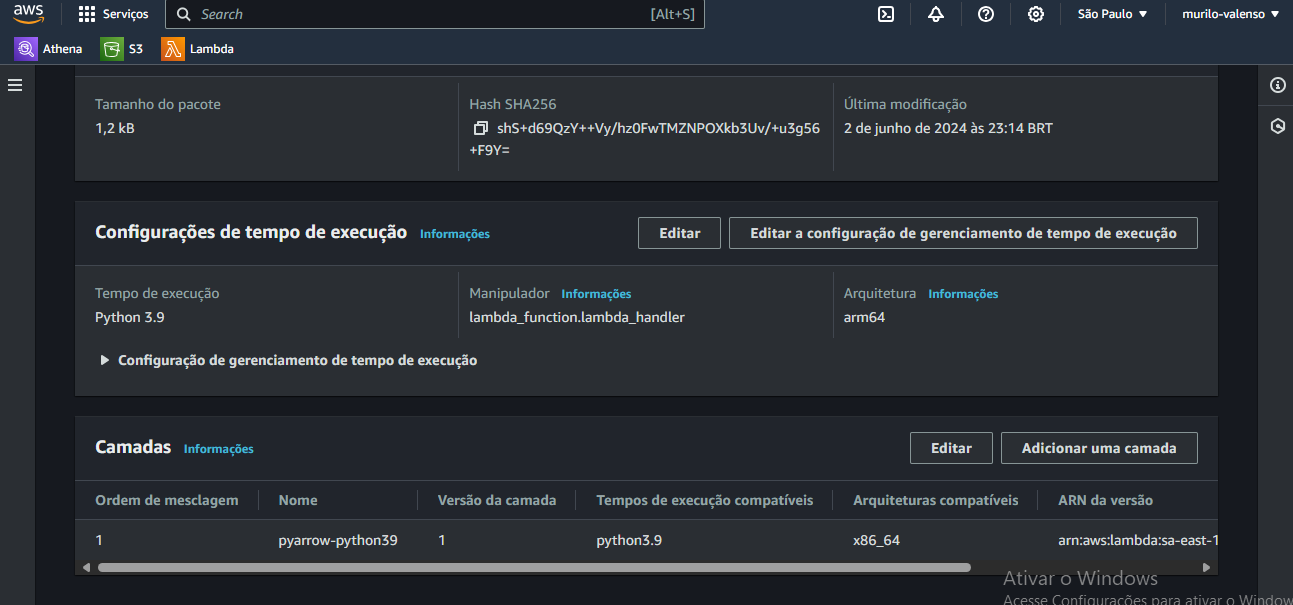

**4.3 AWS Event Bridge**

Na etapa de ETL, o AWS Event Bridge tem a função de ativar diariamente a função de ETL do AWS Lambda, funcionando assim como um scheduler.

> **Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

> **Regra no Event Bridge criada**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/30-eventBridge.png?raw=true)

# 5.1 Apresentação

A etapa de apresentação é reponsável por entregar o dado para os usuários (analistas, cientistas, etc.) e sistemas (dashboards, motores de consultas, etc.), idealmente através de uma interface de fácil uso, como o SQL, logo, essa é a única etapa que a maioria dos usuários terá acesso. Além disso, é importante que as ferramentas da etapa entregem dados armazenados em camadas refinadas, pois assim as consultas são mais baratas e o dados mais consistentes.

**5.1. AWS Athena**

Na etapa de **apresentação**, o AWS Athena tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

> **Código para criar a tabela no Athena:**

CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'

> **Imagem da Tabela criada**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/31-criandoTabela%20(1).png?raw=true)

Por fim, adicionei as partições disponíveis.

> **Importante**: Toda vez que uma nova partição é adicionada ao repositório de dados, é necessário informar o AWS Athena para que a ela esteja disponível via SQL. Para isso, use o comando SQL MSCK REPAIR TABLE <nome-tabela> para todas as partições (mais caro) ou ALTER TABLE <nome-tabela> ADD PARTITION <coluna-partição> = <valor-partição> para uma única partição (mais barato), documentação neste link).
    
> **Código**
    
    MSCK REPAIR TABLE `telegram`;

> **Imagem da Query MSCK realizada**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/32-atualizandoTabela.png?raw=true)

> **Consultei as 10 primeiras linhas para observar o resultado**

Comando: SELECT * FROM `telegram` LIMIT 10;

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/33-10primeirasLinhas.png?raw=true)

**5.2 Analytics**

Com o dado disponível, usuário podem executar as mais variadas consultas analíticas. Seguem alguns exemplos:

> **Quantidade de mensagens por dia.**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/34-qtdemsgspordia.png?raw=true)

> **Quantidade de mensagens por usuário por dia.**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/35-qtdemsgsporusuariopordia.png?raw=true)

> **Média do tamanho das mensagens por usuário por dia.**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/36-mediatamanhomsgsporusuariopordia.png?raw=true)

> **Quantidade de mensagens por hora por dia da semana por número da semana.**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/37-qtde%20msgsporhorapor%20diadasemanapor%20n%C3%BAmerodasemana.png?raw=true)

> **Média do tamanho das mensagens**

![](https://github.com/murilovalenso/Projeto-Pipeline-de-Dados-Telegram/blob/main/Prints%201/38-mediadotamdasmsgs.png?raw=true)

# 6. Conclusão

Utilizando o serviço do **AWS Athena** e queries em **SQL**, é possível extrair insights acerca das mensagens enviadas diariamente via Telegram.